In [1]:
!pip install clip
!pip install lpips

  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=6988 sha256=c520cf016e542c1856d7bf77085224a8d24d725e7f9ea7125766991a6f1ed1b0
  Stored in directory: /root/.cache/pip/wheels/7f/5c/e6/2c0fdb453a3569188864b17e9676bea8b3b7e160c037117869
Successfully built clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.5 MB/s eta 0:00:00


In [2]:
import os
import cv2
import numpy as np
import torch
from PIL import Image
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
from skimage import filters
from skimage.color import rgb2gray
import lpips  # Thư viện LPIPS
#from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt

# Định nghĩa thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load mô hình CLIP
#clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
#clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Load LPIPS model
lpips_model = lpips.LPIPS(net='alex').to(device)  # AlexNet là mạng phổ biến cho LPIPS

# Hàm tính PSNR
def compute_psnr(img1, img2):
    return psnr(img1, img2, data_range=img2.max() - img2.min())

# Hàm tính SSIM
def compute_ssim(img1, img2):
    return ssim(img1, img2, data_range=img2.max() - img2.min(), channel_axis=-1)

# Hàm tính LPIPS
def compute_lpips(img1, img2):
    img1_t = torch.from_numpy(img1).permute(2, 0, 1).float().unsqueeze(0).to(device) / 255.0
    img2_t = torch.from_numpy(img2).permute(2, 0, 1).float().unsqueeze(0).to(device) / 255.0
    return lpips_model(img1_t, img2_t).item()

# Hàm tính sắc nét (sharpness)
def compute_sharpness(image):
    return filters.sobel(image).mean()

# Hàm tính độ nét Laplacian
def compute_clarity(image):
    image_gray = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    return cv2.Laplacian(image_gray, cv2.CV_64F).var()

# Hàm tính độ tương phản
def compute_contrast(image):
    image_gray = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    return image_gray.std()  # RMS contrast

# Hàm phát hiện giọt nước
def detect_raindrops(image):
    image_gray = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    _, thresholded = cv2.threshold(image_gray, 200, 255, cv2.THRESH_BINARY)
    raindrop_percentage = np.mean(thresholded) / 255.0
    return raindrop_percentage  # Giá trị càng cao, ảnh có nhiều giọt nước hơn


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 196MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

len folder 1 731
len folder 2 731
Number of selected images from /kaggle/input/resfusion-inference/submission/: 653
Number of selected images from /kaggle/input/raindrop-pipeline-inference/proposed/700_original/: 78
First 10 selected images: ['/kaggle/input/resfusion-inference/submission/00001.png', '/kaggle/input/resfusion-inference/submission/00002.png', '/kaggle/input/resfusion-inference/submission/00003.png', '/kaggle/input/resfusion-inference/submission/00004.png', '/kaggle/input/resfusion-inference/submission/00005.png', '/kaggle/input/resfusion-inference/submission/00006.png', '/kaggle/input/resfusion-inference/submission/00007.png', '/kaggle/input/resfusion-inference/submission/00008.png', '/kaggle/input/resfusion-inference/submission/00009.png', '/kaggle/input/resfusion-inference/submission/00010.png']
Last 10 selected images: ['/kaggle/input/resfusion-inference/submission/00722.png', '/kaggle/input/resfusion-inference/submission/00723.png', '/kaggle/input/resfusion-inference/

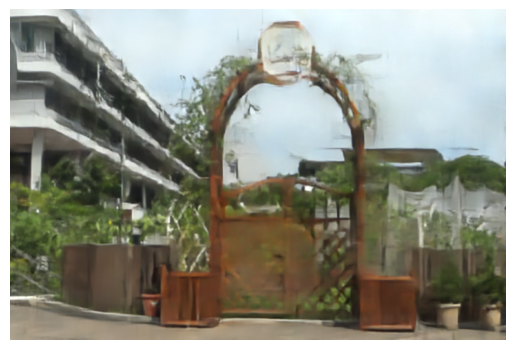

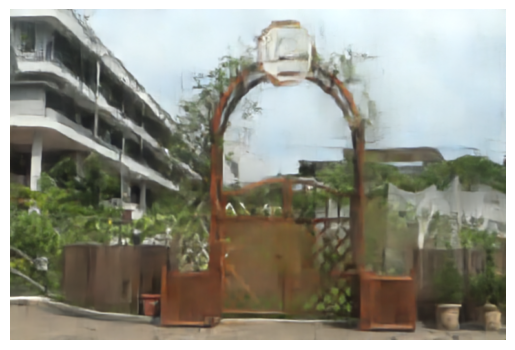

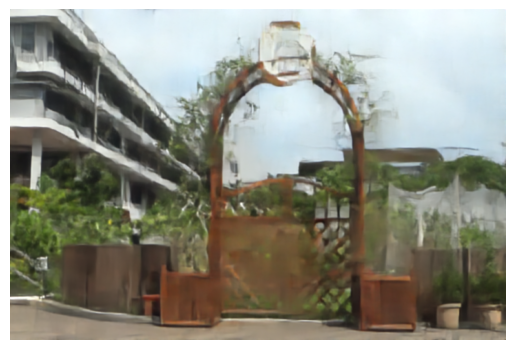

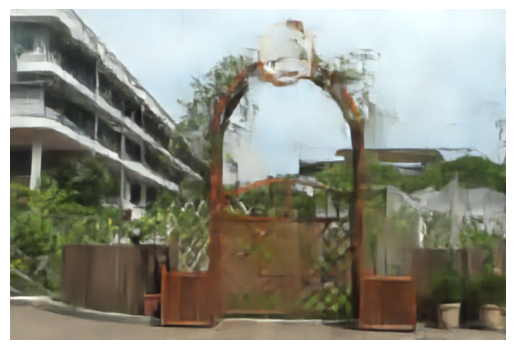

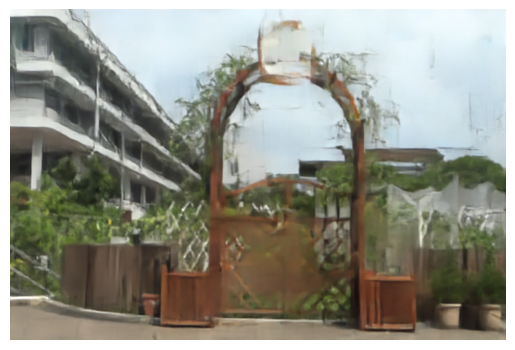

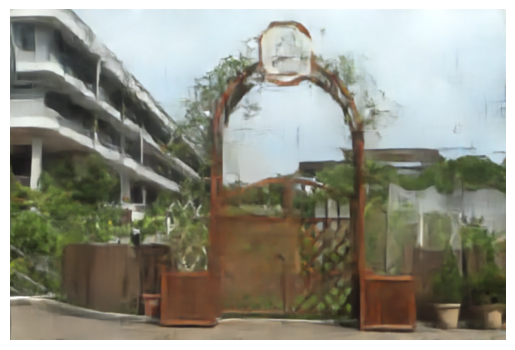

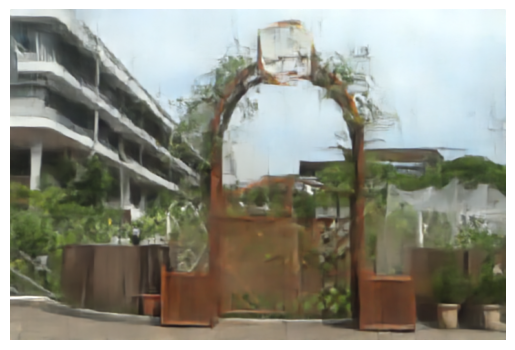

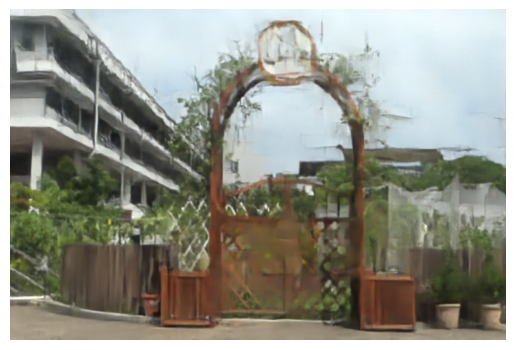

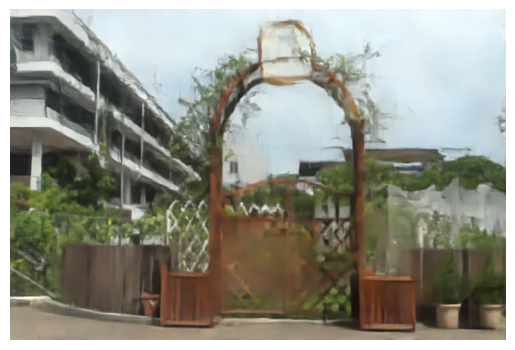

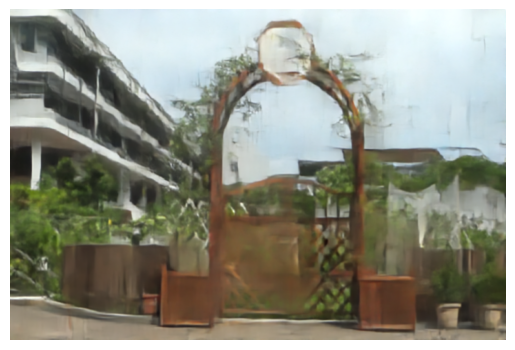

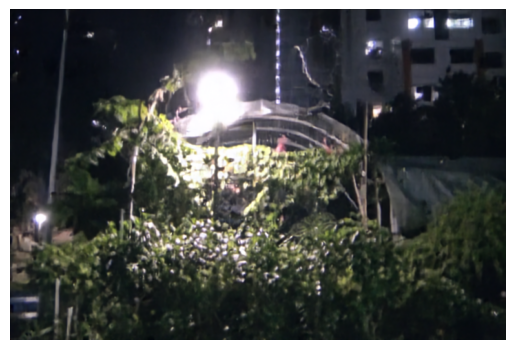

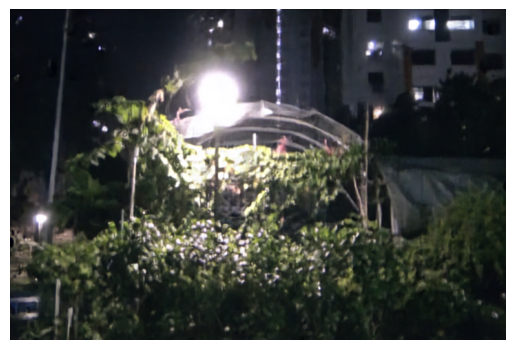

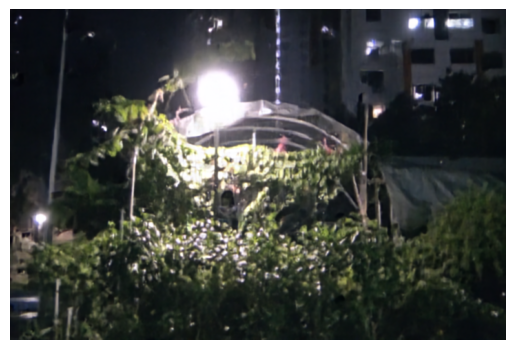

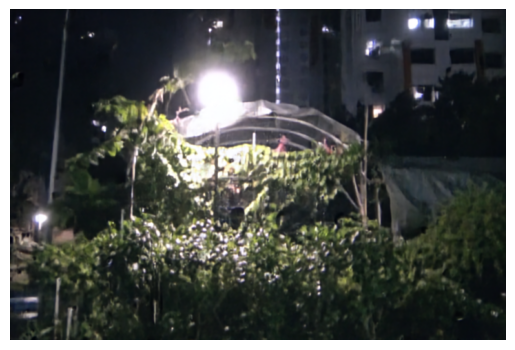

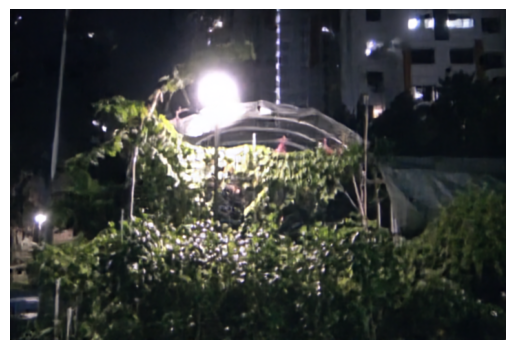

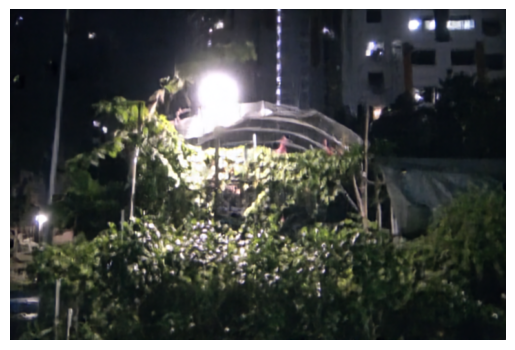

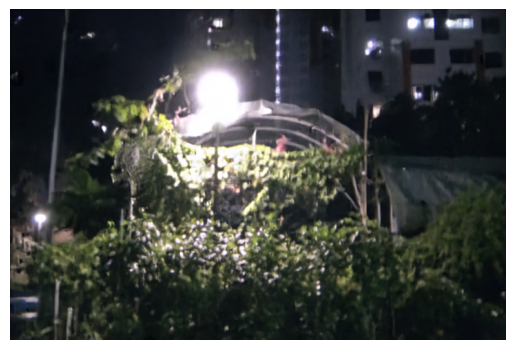

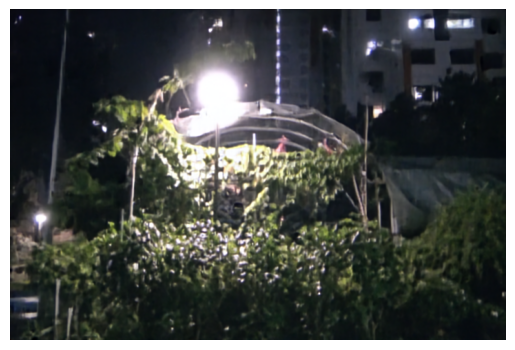

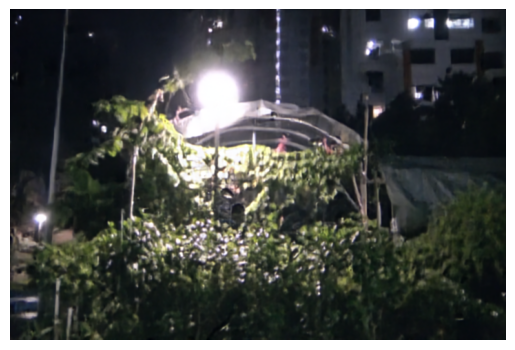

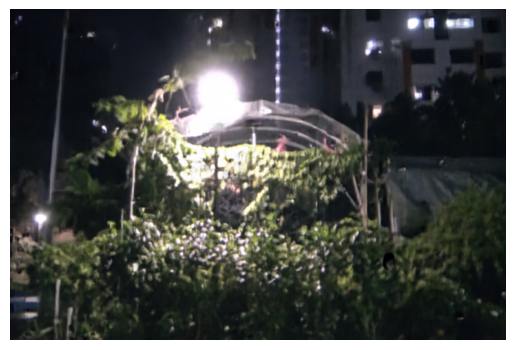

In [3]:
def rank_images(folder1, folder2, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    image_names1 = sorted(os.listdir(folder1))
    image_names2 = sorted(os.listdir(folder2))
    
    image_names = sorted(set(image_names1) & set(image_names2))  # Chỉ lấy các ảnh có trong cả hai thư mục
    results = {}
    count_folder1, count_folder2 = 0, 0  # Counters for images selected from each folder
    
    for img_name in image_names:
        img1_path = os.path.join(folder1, img_name)
        img2_path = os.path.join(folder2, img_name)
        
        # Đọc ảnh RGB
        img1 = cv2.cvtColor(cv2.imread(img1_path), cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(cv2.imread(img2_path), cv2.COLOR_BGR2RGB)

        # Tính toán các chỉ số chất lượng ảnh
        psnr_score = compute_psnr(img1, img2)
        ssim_score = compute_ssim(img1, img2)
        lpips_score = compute_lpips(img1, img2)

        score = psnr_score + 10*ssim_score - 5*lpips_score

        sharpness1, sharpness2 = compute_sharpness(img1), compute_sharpness(img2)
        clarity1, clarity2 = compute_clarity(img1_path), compute_clarity(img2_path)
        contrast1, contrast2 = compute_contrast(img1_path), compute_contrast(img2_path)
        raindrop1, raindrop2 = detect_raindrops(img1_path), detect_raindrops(img2_path)

        # Tính điểm tổng hợp
        score1 = (
            score +
            (sharpness1 * 0.2) + 
            (contrast1 * 0.2) +
            (clarity1 * 0.1)-
            (raindrop1 * 0.5)
        )

        score2 = (
            score +
            (sharpness2 * 0.2) + 
            (contrast2 * 0.2) +
            (clarity2 * 0.1)-
            (raindrop2 * 0.5)
        )

        # Chọn ảnh có điểm cao hơn
        if score1 > score2:
            best_image = img1_path
            count_folder1 += 1
        else:
            best_image = img2_path
            count_folder2 += 1

        results[img_name] = best_image

        # Lưu ảnh tốt hơn vào thư mục đầu ra
        output_path = os.path.join(output_folder, img_name)
        Image.open(best_image).save(output_path)

    return results, count_folder1, count_folder2


# Sử dụng hàm
folder1 = './resfusion_inference'
folder2 = './GAN_inference'
import os
print("len folder 1",len(os.listdir(folder1)))
print("len folder 2",len(os.listdir(folder2)))

output_folder = './ensemble_output'
selected_images, count_folder1, count_folder2 = rank_images(folder1, folder2, output_folder)

# In kết quả
print(f"Number of selected images from {folder1}: {count_folder1}")
print(f"Number of selected images from {folder2}: {count_folder2}")

selected_list = list(selected_images.values())
print("First 10 selected images:", selected_list[:10])
print("Last 10 selected images:", selected_list[-10:])
print("len of submission folder",len(selected_images))
for image_path in selected_list[:10] + selected_list[-10:]:
    image = Image.open(image_path)
    plt.figure()
    plt.imshow(image)
    plt.axis("off")
    plt.show()
